## Question 3: Given the number of acres burned each day by fires in California, binned by size, and wind data, can we predict the air quality in SF on the date that they are contained?


In [1]:
# Dependencies
from sqlalchemy import create_engine
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
rds_connection_string = "root:12345678@127.0.0.1/fires"
engine = create_engine(f'mysql+pymysql://{rds_connection_string}')

In [3]:
data = pd.read_sql("select * from final_binned_daily_data", con=engine)


/anaconda3/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (3719, "'utf8' is currently an alias for the character set UTF8MB3, but will be an alias for UTF8MB4 in a future release. Please consider using UTF8MB4 in order to be unambiguous.")
  result = self._query(query)


In [4]:
data.head()

,index,date,bigger then 300,within 100,within 150,within 200,within 250,within 300,within 50,overall_aqi,avg_daily_wind_speed,fastest_2_min_speed,fastest_5_min_speed
0,0,2001-01-01,1.2,0.0,0.1,0.0,0.1,0.1,0.0,153.0,3.58,10.1,10.1
1,1,2001-01-02,0.3,0.0,0.1,0.0,0.0,0.0,0.0,140.0,2.91,10.1,10.1
2,2,2001-01-03,0.3,0.0,0.0,0.1,0.1,0.0,0.0,140.0,2.68,10.1,10.1
3,3,2001-01-04,5.7,0.0,0.0,4.0,0.0,0.1,0.0,107.0,3.58,8.9,10.1
4,4,2001-01-05,25.7,0.0,24.0,15.0,81.3,0.0,0.0,124.0,4.70,15.0,17.0


In [5]:
data = data[['date', 'within 50', 'within 100', 'within 150', 'within 200', 'within 250', 'within 300', 'bigger then 300', 'avg_daily_wind_speed', 'fastest_2_min_speed', 'fastest_5_min_speed', 'overall_aqi']]
data.head()

,date,within 50,within 100,within 150,within 200,within 250,within 300,bigger then 300,avg_daily_wind_speed,fastest_2_min_speed,fastest_5_min_speed,overall_aqi
0,2001-01-01,0.0,0.0,0.1,0.0,0.1,0.1,1.2,3.58,10.1,10.1,153.0
1,2001-01-02,0.0,0.0,0.1,0.0,0.0,0.0,0.3,2.91,10.1,10.1,140.0
2,2001-01-03,0.0,0.0,0.0,0.1,0.1,0.0,0.3,2.68,10.1,10.1,140.0
3,2001-01-04,0.0,0.0,0.0,4.0,0.0,0.1,5.7,3.58,8.9,10.1,107.0
4,2001-01-05,0.0,0.0,24.0,15.0,81.3,0.0,25.7,4.70,15.0,17.0,124.0


In [6]:
data.describe()

,within 50,within 100,within 150,within 200,within 250,within 300,bigger then 300,avg_daily_wind_speed,fastest_2_min_speed,fastest_5_min_speed,overall_aqi
count,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4598.000000,4599.000000,4583.000000,4599.000000
mean,1.846936,44.879928,218.100889,174.073081,342.328982,274.340198,530.511179,10.285463,23.071689,27.810779,46.785388
std,48.612047,970.625519,4805.078324,2128.344851,6484.653752,4528.334657,7412.340321,4.571428,6.923027,8.368223,19.892289
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.450000,4.900000,6.000000,9.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,6.930000,17.900000,23.000000,33.000000
50%,0.000000,0.000000,0.200000,0.100000,0.100000,0.000000,0.500000,10.290000,23.000000,28.000000,43.000000
75%,0.000000,0.100000,2.500000,1.300000,2.000000,0.600000,5.000000,13.200000,25.900000,32.000000,55.000000
max,3100.250000,47760.100000,255858.000000,75431.100000,315578.800000,162702.000000,288431.200000,28.190000,59.900000,70.900000,179.000000


In [7]:
data = data.fillna(0)

## Supervised machine learning

#### Preparing the data

In [8]:
data.head()

,date,within 50,within 100,within 150,within 200,within 250,within 300,bigger then 300,avg_daily_wind_speed,fastest_2_min_speed,fastest_5_min_speed,overall_aqi
0,2001-01-01,0.0,0.0,0.1,0.0,0.1,0.1,1.2,3.58,10.1,10.1,153.0
1,2001-01-02,0.0,0.0,0.1,0.0,0.0,0.0,0.3,2.91,10.1,10.1,140.0
2,2001-01-03,0.0,0.0,0.0,0.1,0.1,0.0,0.3,2.68,10.1,10.1,140.0
3,2001-01-04,0.0,0.0,0.0,4.0,0.0,0.1,5.7,3.58,8.9,10.1,107.0
4,2001-01-05,0.0,0.0,24.0,15.0,81.3,0.0,25.7,4.70,15.0,17.0,124.0


In [9]:
X = data.drop(['date', 'overall_aqi'],axis=1)


In [10]:
X.head()

,within 50,within 100,within 150,within 200,within 250,within 300,bigger then 300,avg_daily_wind_speed,fastest_2_min_speed,fastest_5_min_speed
0,0.0,0.0,0.1,0.0,0.1,0.1,1.2,3.58,10.1,10.1
1,0.0,0.0,0.1,0.0,0.0,0.0,0.3,2.91,10.1,10.1
2,0.0,0.0,0.0,0.1,0.1,0.0,0.3,2.68,10.1,10.1
3,0.0,0.0,0.0,4.0,0.0,0.1,5.7,3.58,8.9,10.1
4,0.0,0.0,24.0,15.0,81.3,0.0,25.7,4.70,15.0,17.0


In [11]:
y = data['overall_aqi'].values.reshape(-1,1)
print(X.shape, y.shape)

(4599, 10) (4599, 1)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Linear Regression

In [13]:
model=LinearRegression()

In [14]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)



print(f"Linear Regression Training Score: {training_score}")
print(f"Linear Regression Testing Score: {testing_score}")

Linear Regression Training Score: 0.1841771580414373
Linear Regression Testing Score: 0.19404673551274532


Text(0.5,1,'Residual Plot')

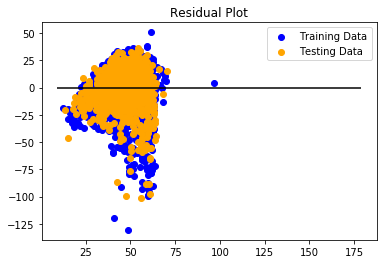

In [16]:
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")

#### K Neighbors Regressor

In [17]:
knr = KNeighborsRegressor(n_neighbors=10)

In [18]:
knr.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')

In [19]:
knr.fit(X_train, y_train)
training_score = knr.score(X_train, y_train)
testing_score = knr.score(X_test, y_test)



print(f"K Neighbors Regressor Training Score: {training_score}")
print(f"K Neighbors Regressor Testing Score: {testing_score}")

K Neighbors Regressor Training Score: 0.3127423399129645
K Neighbors Regressor Testing Score: 0.13896461495176204


#### Gradient Boosting Regressor

In [20]:
gbr = GradientBoostingRegressor(n_estimators=200)

In [21]:
gbr.fit(X_train, y_train)
training_score = gbr.score(X_train, y_train)
testing_score = gbr.score(X_test, y_test)



print(f"Gradient Boosting Regressor Training Score: {training_score}")
print(f"Gradient Boosting Regressor Testing Score: {testing_score}")

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Gradient Boosting Regressor Training Score: 0.48007173850435325
Gradient Boosting Regressor Testing Score: 0.2931617779788901


#### Random Forest Regressor

In [22]:
rfr = RandomForestRegressor(n_estimators=50)

In [23]:
rfr.fit(X_train, y_train)
training_score = rfr.score(X_train, y_train)
testing_score = rfr.score(X_test, y_test)



print(f"Random Forest Regressor Training Score: {training_score}")
print(f"Random Forest Regressor Testing Score: {testing_score}")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


Random Forest Regressor Training Score: 0.8884730848946363
Random Forest Regressor Testing Score: 0.274260105492361


## Unsupervised machine learning

In [24]:
X = data.drop(['date'],axis=1)

In [25]:
X.head()

,within 50,within 100,within 150,within 200,within 250,within 300,bigger then 300,avg_daily_wind_speed,fastest_2_min_speed,fastest_5_min_speed,overall_aqi
0,0.0,0.0,0.1,0.0,0.1,0.1,1.2,3.58,10.1,10.1,153.0
1,0.0,0.0,0.1,0.0,0.0,0.0,0.3,2.91,10.1,10.1,140.0
2,0.0,0.0,0.0,0.1,0.1,0.0,0.3,2.68,10.1,10.1,140.0
3,0.0,0.0,0.0,4.0,0.0,0.1,5.7,3.58,8.9,10.1,107.0
4,0.0,0.0,24.0,15.0,81.3,0.0,25.7,4.70,15.0,17.0,124.0


In [26]:
pca = PCA(n_components=2)

In [27]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [28]:
pca_data = pca.transform(X)

In [29]:
kmeans= KMeans(n_clusters=2)

In [30]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

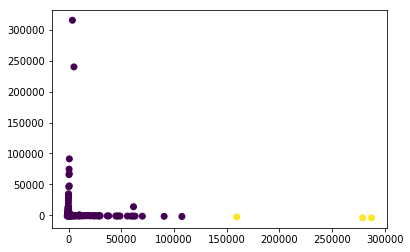

In [31]:
plt.scatter(pca_data[:,0],pca_data[:,1],c=kmeans.labels_)

In [32]:
pca_data

array([[-543.55287785, -335.82218954],
       [-544.45658156, -335.90988568],
       [-544.45502582, -335.80898918],
       ...,
       [-544.5016364 , -335.90522561],
       [-544.74247456, -335.90287955],
       [-544.66035771, -335.90679098]])